<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson7_resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.1.1

    100% |████████████████████████████████| 532.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5fa16000 @  0x7fbbf145d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 2.0MB 7.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 153kB 4.4MB/s 
    100% |████████████████████████████████| 112kB 5.1MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ |

## MNIST CNN

MNISTを例として様々なアーキテクチャを構築する．

最初は単純な畳み込みニューラルネットである．

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
from fastai.vision import *

### Data

In [0]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [7]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/4/6941.png')

In [0]:
defaults.cmap='binary'

In [8]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png

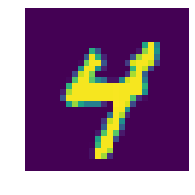

In [9]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/2')]

In [0]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

4 torch.Size([1, 28, 28])


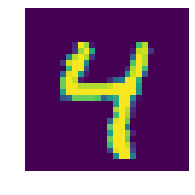

In [16]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

4


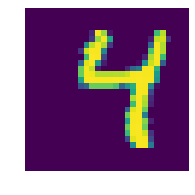

In [22]:
x.show()
print(y)

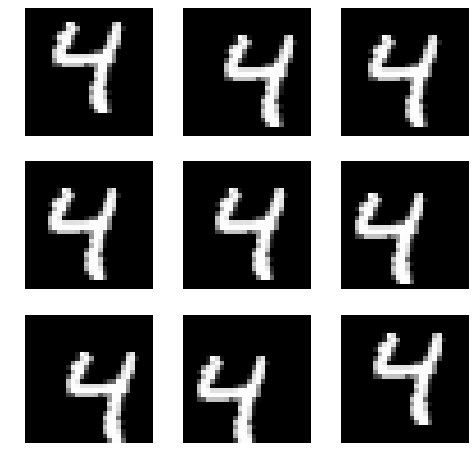

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

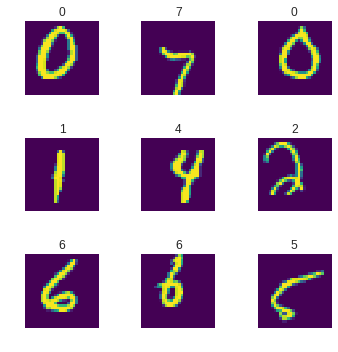

In [25]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (60000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, moment

In [0]:
#xb = xb.cuda()

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


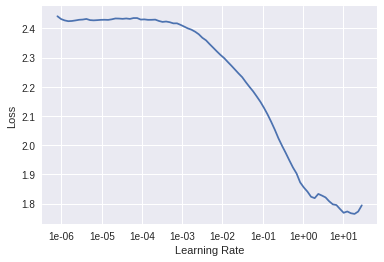

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.211631,0.123041,0.960800
2,0.137152,0.075608,0.976100
3,0.075212,0.041820,0.986200


### Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.238466,0.169266,0.947300
2,0.186934,0.281831,0.901900
3,0.159447,0.191179,0.939600
4,0.135500,0.417130,0.863300
5,0.130170,0.079991,0.975300
6,0.102119,0.102389,0.965000
7,0.077528,0.047130,0.985000
8,0.062439,0.046351,0.985400
9,0.047078,0.032539,0.988700
10,0.043164,0.030783,0.989000


### Resnet-ish

残差ブロックの定義


ブロック内では2つの畳み込み層を準備する．

実際の計算(forward)では，入力xを2つの畳み込み層に順に通したものと，入力そのものの和を返すようにする．

これによって，層が増えたときに発生する勾配消失（もしくは勾配爆発）現象を回避できる．

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [40]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


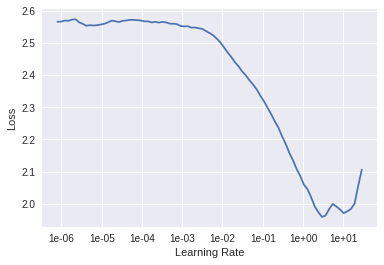

In [45]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.251959,0.160960,0.957500
2,0.144515,0.275723,0.911000
3,0.106059,0.091391,0.969100
4,0.083519,0.085967,0.974300
5,0.075442,0.043198,0.986600
6,0.065817,0.055602,0.984000
7,0.055837,0.043179,0.987400
8,0.039493,0.023791,0.994000
9,0.032009,0.019174,0.993400
10,0.026442,0.018781,0.993700


In [47]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (60000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layer

## fin